In [162]:
from pathlib import Path

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

### Load data

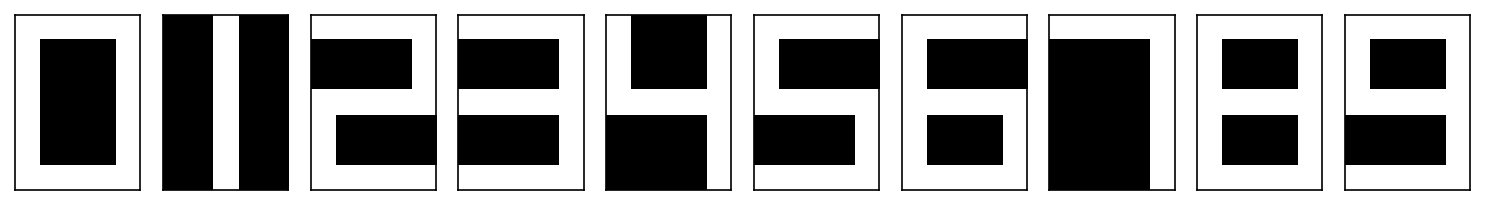

In [163]:
img_shape = (7, 5)
img_size = 35

data_path = Path('/mnt/HDD500GB/Data/development/jupyterLab/data/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [164]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [165]:
features = []
labels = []

for i, reference_sample in enumerate(data_mtrx):
    features.append(reference_sample)
    labels.append(one_hot_encoding(10, i))

    for j in range(9):
        noised_sample = reference_sample + np.random.uniform(0.0, 0.25, img_size)
        
        features.append(noised_sample)
        labels.append(one_hot_encoding(10, i))

features = np.array(features)
labels = np.array(labels)

### Split dataset to train and test

In [166]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = np.array(features[idx_test])
y_test = np.array(labels[idx_test])

x_train = np.array(features[idx_train])
y_train = np.array(labels[idx_train])

### Activation functions

In [167]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)

@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)

@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)

@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Model

In [185]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray, c: np.ndarray, W: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    dc = np.zeros(c.shape)

    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    U = np.zeros((V.shape[0], V.shape[1]))
    H = np.zeros((V.shape[0], V.shape[1]))
    
    for i in range(x_batch.shape[0]):
        for j in range(V.shape[0]):
            U[j] = V[j] @ x_batch[i] + c[j]
            H[j] = sigmoid(U[j])
        
        z = np.sum(H * W, axis=0) + b

        y = softmax(z)

        for j in range(V.shape[0]):
            dLdu = (y - y_batch[i]) * W[j] * dSigmoid(U[j])
            dV[j] += np.outer(dLdu , x_batch[i])
            dc[j] += dLdu
        
        dW += H * (y - y_batch[i])
        db += y - y_batch[i]
    
    return (dV, dc, dW, db)


class WidePerceptron:
    def __init__(self, nIn: int, nOut: int, nL:int) -> None:
        self.nIn = nIn
        self.nL = nL
        self.nOut = nOut
        
        self.V: np.ndarray = np.random.uniform(-1, 1, (nL, nOut, nIn))
        self.c: np.ndarray = np.zeros((nL, nOut))

        self.W: np.ndarray = np.random.uniform(-1, 1, (nL, nOut))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x:np.ndarray) -> np.ndarray:
        H = np.zeros((self.nL, self.nOut))

        for i in range(self.nL):
            H[i] = sigmoid(self.V[i] @ x + self.c[i])
        
        z = np.sum(H * self.W, axis=0) + self.b
                
        return softmax(z)
    
    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        Ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(Ypred), axis=1)
        return np.mean(h)
    
    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for batch_idx in range(n//batch_size):
                ibegin = batch_idx * batch_size
                iend = min((batch_idx + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]
            
                dV, dc, dW, db = grads(x_train[batch_idxs], y_train[batch_idxs], self.V, self.c, self.W, self.b)

                self.V -= lr * dV
                self.c -= lr * dc

                self.W -= lr * dW
                self.b -= lr * db

### Create and train model

In [191]:
nIn = 35
nL = 3
nOut = 10

lr = 1e-1
batch_size = 8
max_epoch = 300

model = WidePerceptron(nIn, nOut, nL)

print('untrained loss: {0:.6f}'.format(model.loss(x_test, y_test)))

model.train(x_train, y_train, lr, batch_size, max_epoch)

print('trained loss: {0:.6f}'.format(model.loss(x_test, y_test)))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = n_true_pos / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss: 0.235494
trained loss: 0.000412
test set accuracy: 100.0%


### Test model on noised examples

In [192]:
n_samples = 10000
noise_size = 1.0

n_true_pos = 0

for i in range(n_samples):
    j = i % 10
    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    y = model.predict(x)
    n_true_pos += 1 if j == np.argmax(y) else 0

print(f"accuracy: {round(n_true_pos / n_samples * 100, 2)}%")

accuracy: 94.05%


### Visualize model predictions

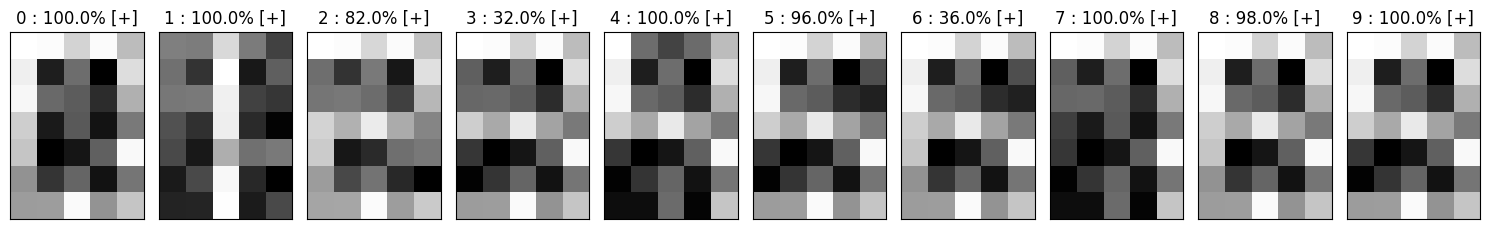

In [194]:
noise_size = 1.0
noise = np.random.uniform(0.0, noise_size, img_size)

x_noised = data_mtrx + noise
y = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    j = np.argmax(y[i])

    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    ax.set_title(f"{j} : {(y[i][j] * 100).round()}% [{'+' if j == i else '-'}]")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()